Project-3 Shuzo Katayama, October 4 2020

This project takes data from the Wisconsin Breast Cancer dataset that is built into scikit-learn. In order to classify tissue into malignant or benign tissue, I will consider the mean radius and the mean compactness (the square of the perimeter divided by the area minus 1).

Data from: https://www.kaggle.com/uciml/breast-cancer-wisconsin-data

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
plt.rcdefaults()

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
class LogisticRegressionGD(object):
    """Logistic Regression Classifier using gradient descent.

    Parameters
    ------------
    eta : float
      Learning rate (between 0.0 and 1.0)
    n_iter : int
      Passes over the training dataset.
    random_state : int
      Random number generator seed for random weight
      initialization.


    Attributes
    -----------
    w_ : 1d-array
      Weights after fitting.
    cost_ : list
      Logistic cost function value in each epoch.

    """
    def __init__(self, eta=0.05, n_iter=100, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state

    def fit(self, X, y):
        """ Fit training data.

        Parameters
        ----------
        X : {array-like}, shape = [n_examples, n_features]
          Training vectors, where n_examples is the number of examples and
          n_features is the number of features.
        y : array-like, shape = [n_examples]
          Target values.

        Returns
        -------
        self : object

        """
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1 + X.shape[1])
        self.cost_ = []

        for i in range(self.n_iter):
            net_input = self.net_input(X)
            output = self.activation(net_input)
            errors = (y - output)
            self.w_[1:] += self.eta * X.T.dot(errors)
            self.w_[0] += self.eta * errors.sum()
            
            # note that we compute the logistic `cost` now
            # instead of the sum of squared errors cost
            cost = -y.dot(np.log(output)) - ((1 - y).dot(np.log(1 - output)))
            self.cost_.append(cost)
        return self
    
    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def activation(self, z):
        """Compute logistic sigmoid activation"""
        return 1. / (1. + np.exp(-np.clip(z, -250, 250)))

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.net_input(X) >= 0.0, 1, 0)
        # equivalent to:
        # return np.where(self.activation(self.net_input(X)) >= 0.5, 1, 0)

In [3]:
class AdalineSGD(object):
    """ADAptive LInear NEuron classifier.

    Parameters
    ------------
    eta : float
      Learning rate (between 0.0 and 1.0)
    n_iter : int
      Passes over the training dataset.
    shuffle : bool (default: True)
      Shuffles training data every epoch if True to prevent cycles.
    random_state : int
      Random number generator seed for random weight
      initialization.


    Attributes
    -----------
    w_ : 1d-array
      Weights after fitting.
    cost_ : list
      Sum-of-squares cost function value averaged over all
      training examples in each epoch.

        
    """
    def __init__(self, eta=0.01, n_iter=10, shuffle=True, random_state=None):
        self.eta = eta
        self.n_iter = n_iter
        self.w_initialized = False
        self.shuffle = shuffle
        self.random_state = random_state
        
    def fit(self, X, y):
        """ Fit training data.

        Parameters
        ----------
        X : {array-like}, shape = [n_examples, n_features]
          Training vectors, where n_examples is the number of examples and
          n_features is the number of features.
        y : array-like, shape = [n_examples]
          Target values.

        Returns
        -------
        self : object

        """
        self._initialize_weights(X.shape[1])
        self.cost_ = []
        for i in range(self.n_iter):
            if self.shuffle:
                X, y = self._shuffle(X, y)
            cost = []
            for xi, target in zip(X, y):
                cost.append(self._update_weights(xi, target))
            avg_cost = sum(cost) / len(y)
            self.cost_.append(avg_cost)
        return self

    def _shuffle(self, X, y):
        """Shuffle training data"""
        r = self.rgen.permutation(len(y))
        return X[r], y[r]
    
    def _initialize_weights(self, m):
        """Initialize weights to small random numbers"""
        self.rgen = np.random.RandomState(self.random_state)
        self.w_ = self.rgen.normal(loc=0.0, scale=0.01, size=1 + m)
        self.w_initialized = True
        
    def _update_weights(self, xi, target):
        """Apply Adaline learning rule to update the weights"""
        output = self.activation(self.net_input(xi))
        error = (target - output)
        self.w_[1:] += self.eta * xi.dot(error)
        self.w_[0] += self.eta * error
        cost = 0.5 * error**2
        #print(self.w_)
        #print("xi:", xi, "target:", target, "output:", output, "error:", error)
        return cost
    
    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def activation(self, X):
        """Compute linear activation"""
        return X

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.activation(self.net_input(X)) >= 0.0, 1, 0)


In [4]:
df = pd.read_csv('breast_cancer.csv')
df

id diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0      842302         M        17.99         10.38          122.80     1001.0   
1      842517         M        20.57         17.77          132.90     1326.0   
2    84300903         M        19.69         21.25          130.00     1203.0   
3    84348301         M        11.42         20.38           77.58      386.1   
4    84358402         M        20.29         14.34          135.10     1297.0   
..        ...       ...          ...           ...             ...        ...   
564    926424         M        21.56         22.39          142.00     1479.0   
565    926682         M        20.13         28.25          131.20     1261.0   
566    926954         M        16.60         28.08          108.30      858.1   
567    927241         M        20.60         29.33          140.10     1265.0   
568     92751         B         7.76         24.54           47.92      181.0   

     smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0            0.11840           0.27760         0.30010              0.14710   
1            0.08474           0.07864         0.08690              0.07017   
2            0.10960           0.15990         0.19740              0.12790   
3            0.14250           0.28390         0.24140              0.10520   
4            0.10030           0.13280         0.19800              0.10430   
..               ...               ...             ...                  ...   
564          0.11100           0.11590         0.24390              0.13890   
565          0.09780           0.10340         0.14400              0.09791   
566          0.08455           0.10230         0.09251              0.05302   
567          0.11780           0.27700         0.35140              0.15200   
568          0.05263           0.04362         0.00000              0.00000   

     ...  texture_worst  perimeter_worst  area_worst  smoothness_worst  \
0    ...          17.33           184.60      2019.0           0.16220   
1    ...          23.41           158.80      1956.0           0.12380   
2    ...          25.53           152.50      1709.0           0.14440   
3    ...          26.50            98.87       567.7           0.20980   
4    ...          16.67           152.20      1575.0           0.13740   
..   ...            ...              ...         ...               ...   
564  ...          26.40           166.10      2027.0           0.14100   
565  ...          38.25           155.00      1731.0           0.11660   
566  ...          34.12           126.70      1124.0           0.11390   
567  ...          39.42           184.60      1821.0           0.16500   
568  ...          30.37            59.16       268.6           0.08996   

     compactness_worst  concavity_worst  concave points_worst  symmetry_worst  \
0              0.66560           0.7119                0.2654          0.4601   
1              0.18660           0.2416                0.1860          0.2750   
2              0.42450           0.4504                0.2430          0.3613   
3              0.86630           0.6869                0.2575          0.6638   
4              0.20500           0.4000                0.1625          0.2364   
..                 ...              ...                   ...             ...   
564            0.21130           0.4107                0.2216          0.2060   
565            0.19220           0.3215                0.1628          0.2572   
566            0.30940           0.3403                0.1418          0.2218   
567            0.86810           0.9387                0.2650          0.4087   
568            0.06444           0.0000                0.0000          0.2871   

     fractal_dimension_worst  Unnamed: 32  
0                    0.11890          NaN  
1                    0.08902          NaN  
2                    0.08758          NaN  
3                    0.17300          NaN  
4      

In [5]:
a = df.to_numpy()

This loop converts Malignant classifications ('M') to 0, and Benign classifications ('B') to 1

In [6]:
for item in a:
    if item[1] == "M":
        item[1] = 0
    else:
        item[1] = 1

Classifying into Malignant (0) and Benign (1) tissue

In [7]:
# Malignant tissue
malignant = a[a[:,1]==0, :32]
# Benign tissue
benign = a[a[:,1]==1, :32]

Plotting Malignant and Benign tissue

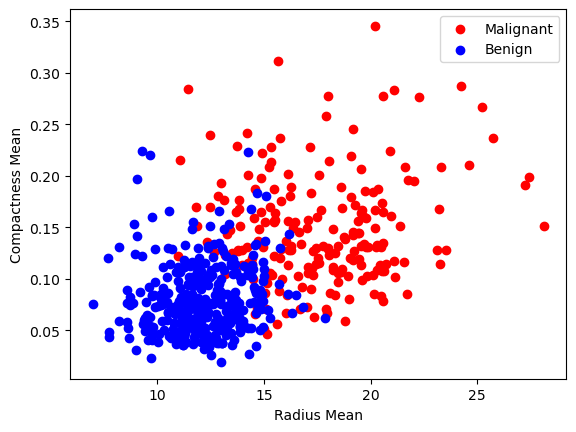

In [8]:
plt.scatter(malignant[:, 2], malignant[:, 7], color='red', marker='o', label='Malignant')
plt.scatter(benign[:, 2], benign[:, 7], color='blue', marker='o', label='Benign')
plt.xlabel('Radius Mean')
plt.ylabel('Compactness Mean')
plt.legend(loc='upper right')
plt.show()

Here the data shows that, in general, tissue that is larger (in radius) and more compact is more likely to be malignant, and tissue that is less compact and smaller (in radius) is more likely to be benign

Here, I am cleaning the data to be fed to the two algorithms

In [9]:
# Splitting into features (X) and targets(y)
X = a[:, [2,7]]
X = X.astype('float64')
y = a[:, 1]
y = y.astype('float64')

In [10]:
# Splitting into training and test sets
# Code from svm example
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

In [11]:
# Standardising data
# Code from svm example

sc = StandardScaler()
sc.fit(X_train) ## Note that we standard only on the basis of the training set
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

X_combined_std = np.vstack((X_train_std, X_test_std))
y_combined = np.hstack((y_train, y_test))

In [12]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=cl, 
                    edgecolor='black')

    # highlight test examples
    if test_idx:
        # plot all examples
        X_test, y_test = X[test_idx, :], y[test_idx]

        plt.scatter(X_test[:, 0],
                    X_test[:, 1],
                    c=[], #c='', ## CHANGED TO AVOID A WARNING
                    edgecolor='black',
                    alpha=1.0,
                    linewidth=1,
                    marker='o',
                    s=100, 
                    label='test set')

In this project, I will be comparing the performance of the Adaline model and the Logistic Regression model on this dataset. In principle, the only difference between these two models is the activation function, which is linear in Adaline, and a sigmoid function in the Logistic Regression Model. This means extreme training examples will have less weight on the weight updates.

For this project, the task that the two models will be performing is the classification of benign tissue or malignant tissue, based off of the mean radius and mean compactness of that sample. 

Training Adaline

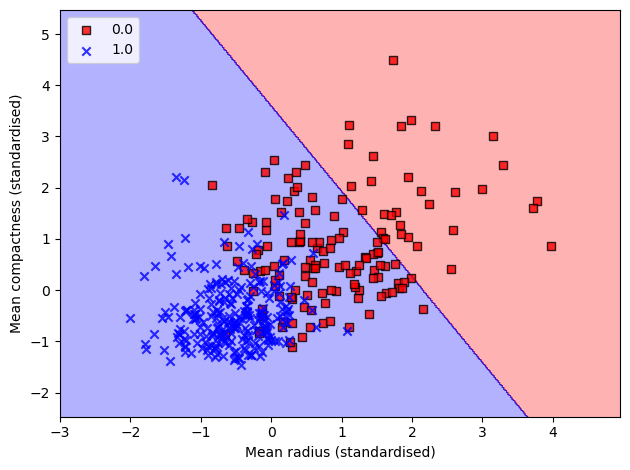

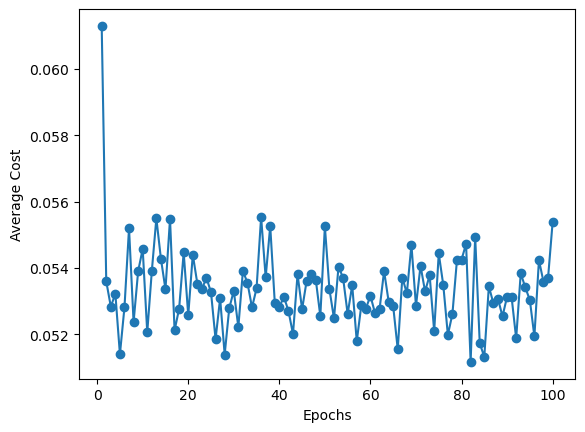

In [13]:
X_train_01_subset = X_train_std[(y_train == 0) | (y_train == 1)]
y_train_01_subset = y_train[(y_train == 0) | (y_train == 1)]

ada_sgd = AdalineSGD(n_iter=100, eta=0.05, random_state=1)
ada_sgd.fit(X_train_01_subset, y_train_01_subset)

plot_decision_regions(X=X_train_01_subset, 
                      y=y_train_01_subset,
                      classifier=ada_sgd)

plt.xlabel('Mean radius (standardised)')
plt.ylabel('Mean compactness (standardised)')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

plt.plot(range(1, len(ada_sgd.cost_) + 1), ada_sgd.cost_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Average Cost')
plt.show()

Training Linear Regression

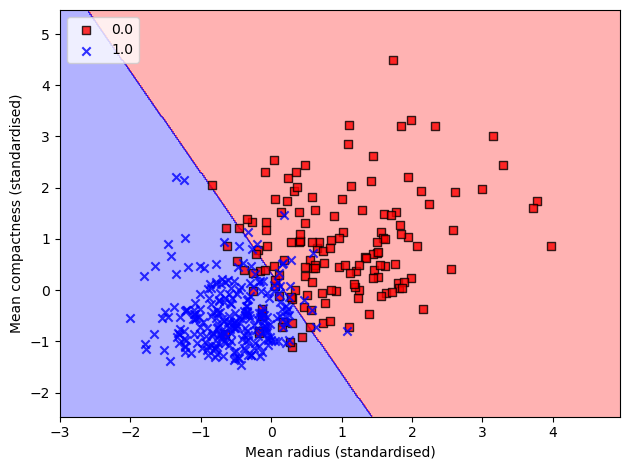

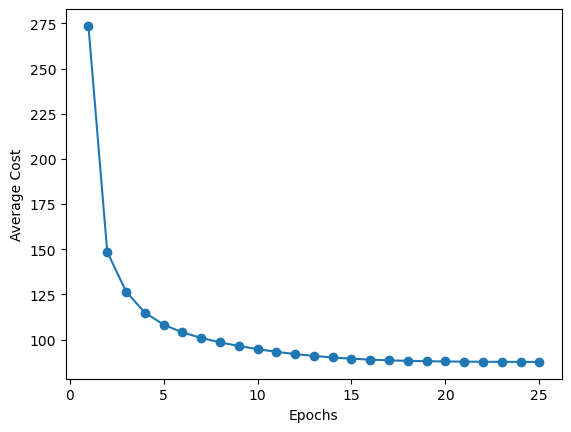

In [14]:
X_train_01_subset = X_train_std[(y_train == 0) | (y_train == 1)]
y_train_01_subset = y_train[(y_train == 0) | (y_train == 1)]

lrgd = LogisticRegressionGD(eta=0.05, n_iter=25, random_state=1)
lrgd.fit(X_train_01_subset, y_train_01_subset)

plot_decision_regions(X=X_train_01_subset, 
                      y=y_train_01_subset,
                      classifier=lrgd)

plt.xlabel('Mean radius (standardised)')
plt.ylabel('Mean compactness (standardised)')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

plt.plot(range(1, len(lrgd.cost_) + 1), lrgd.cost_, marker='o')

plt.xlabel('Epochs')
plt.ylabel('Average Cost')
plt.show()

I will be comparing the two models in terms of their accuracy on predicting the test set. In this comparison, I will run .predict() and then take the accuracy as the number of correct predictions over the number of items in the test set.

Testing Adaline

In [15]:
y_test

array([0., 1., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 1., 1., 1., 0.,
       1., 0., 0., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0.,
       1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1.,
       1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 0., 0., 0., 1.,
       1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 0.,
       1., 0., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 1., 1., 0., 0., 1.,
       1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 0., 0., 1., 0., 0.,
       1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 0.,
       1., 1., 0., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 0., 1., 0., 1.,
       1., 0., 1., 1., 0., 1., 1., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0.,
       0.])

In [16]:
y_results = ada_sgd.predict(X_test_std[:, :])
y_results

array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [17]:
counter = 0
correct_counter = 0
for t in y_test:
    if y_results[counter] == t:
        correct_counter = correct_counter+1
    counter = counter+1
        

In [18]:
counter

171

In [19]:
correct_counter

121

In [20]:
accuracy = correct_counter / counter
accuracy

0.7076023391812866

Testing Linear Regression

In [21]:
y_results = lrgd.predict(X_test_std[:, :])
y_results

array([0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1,
       1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1,
       1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1,
       1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1,
       1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1,
       0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0,
       0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0])

In [22]:
counter = 0
correct_counter = 0
for t in y_test:
    if y_results[counter] == t:
        correct_counter = correct_counter+1
    counter = counter+1
        

In [23]:
counter

171

In [24]:
correct_counter

158

In [25]:
accuracy = correct_counter / counter
accuracy

0.9239766081871345

Comparison and Conclusion

In the comparison of the two models, I compared the time it took for the average cost of the two models to converge, and the accuracy of the two models in terms of their success on predicting items in the test set. Unlike the last set I used, this set is not linearly separable, so the models were not able to completely generalise the pattern and create a model that is 100% accurate. However, with these two metrics of comparison, the Adaline model and the Linear Regression model are comparable. 

The Adaline model's average cost converges very quickly. After about two or three epochs, it reaches about where the average cost lies, no matter how much more it is trained. The Linear Regression model takes longer for it to reach convergence: after about 20 epochs. 

The Linear Regression Model, however, turns out to be more accurate than the Adaline model. Out of 171 test examples, the Adaline model was able to predict 121 of them correctly, for an accuracy rate of about 70.8%. On the other hand, the Linear Regression Model predicted 158 out of 171 examples correctly, for a rate of about 92.4%.

In conclusion, Adaline learned faster, but was more inaccurate, and the Linear Regression model learned slower, but it was more accurate.